In [1]:
import os
import sys
import torch
import cv2
import time
import numpy as np
from skimage import io
from PIL import Image
import pytorch3d
from pytorch3d import ops
from pytorch3d import structures
import open3d as o3d
import kornia
from kornia.geometry.depth import depth_to_normals
import glob
import matplotlib.pyplot as plt

In [2]:
# GPU availability check
torch.cuda.is_available()

True

In [3]:
# load data
cam_pose = np.loadtxt('sample_cam_pose.txt')

down_sampling_rate = 3
pc_offset = np.array([4368053.443661253, 502836.24879749375, 4605424.628245384])
pc_xyz_ = np.load('sample_point_cloud.npy').astype(float)
pc_xyz_ = (pc_xyz_ != -1) * (pc_xyz_ - pc_offset[None, None, :]) + pc_xyz_ * (pc_xyz_ == -1) 
pc_xyz_ = pc_xyz_[::down_sampling_rate, ::down_sampling_rate, :]  # [H_ds, W_ds, 3] ~= [60, 90, 3]

pc_xyz = pc_xyz_.copy().reshape(-1, 3)
pc_xyz = pc_xyz[np.sum(pc_xyz, axis=1) != -3]
pc_xyz.shape

(28933, 3)

In [4]:
def analyze_normal(normals):
    """
    Analyze the surface normal matrix.
    @param normals: [N, 3] normalized surface normal vectors
    """
    mask_nodata = np.sum(normals, axis=1) == -3
    normals = normals[np.logical_not(mask_nodata)]
    if np.sum(mask_nodata):
        print("{:d} out of {:d} rows are removed becaues of no-data.".format(np.sum(mask_nodata), len(mask_nodata)))
    
    z_value = normals[:, -1]
    print("Surface normal shape: {}, mean: {:.2f}, median: {:.2f}".format(normals.shape, np.mean(z_value), np.median(z_value)))
    print("Z-direction value: {:d} / {:d} negative, {:d} / {:d} positive".format(np.sum(z_value<0), len(normals), np.sum(z_value>=0), len(normals)))

# Use pytorch3d for surface normal estimation

In [5]:
# Use pytorch3d for surface normal estimation
pc_pt3d = structures.Pointclouds(torch.tensor(pc_xyz).unsqueeze(0).float())

time_start = time.time()
norm_pt3d = pc_pt3d.estimate_normals(neighborhood_size=50, disambiguate_directions=False)
time_pt3d = time.time() - time_start

print("Time for surface normal estimation using pytorch3d: {:.1f}ms".format(time_pt3d * 1e3))

Time for surface normal estimation using pytorch3d: 8677.7ms


/home/qiyan/Documents/pytorch3d-official/pytorch3d/ops/points_normals.py:136: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  curvatures, local_coord_frames = torch.symeig(cov, eigenvectors=True)


Surface normal shape: (28933, 3), mean: 0.49, median: 0.72
Z-direction value: 4881 / 28933 negative, 24052 / 28933 positive


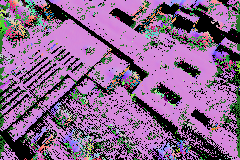

In [6]:
# Save pytorch3d results
analyze_normal(norm_pt3d.cpu().reshape(-1, 3).numpy())

out_norm_pt3d = torch.tensor(pc_xyz_).float().reshape(-1, 3)
out_norm_pt3d[torch.sum(out_norm_pt3d, axis=1)!=-3] = norm_pt3d.cpu().reshape(-1, 3)
out_norm_pt3d = out_norm_pt3d.reshape(pc_xyz_.shape)
out_norm_pt3d.shape

out_norm_pt3d += 1
out_norm_pt3d /= 2
out_norm_pt3d *= 255

cv2.imwrite('surface_normal_pt3d.png', out_norm_pt3d.numpy())

Image.fromarray(np.uint8(out_norm_pt3d.numpy()))

# Use kornia for surface normal estimation

In [7]:
# Use kornia for surface normal estimation

intrinsics = torch.tensor([[480.0 / 3, 0, pc_xyz_.shape[1] // 2, 0],
                            [0, 720.0 / 3, pc_xyz_.shape[0] // 2, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]).unsqueeze(0).cuda()  # [1, 4, 4]

# Convert world coords into cam coords
world2cam_mat = torch.tensor(np.linalg.inv(cam_pose), device='cuda').float()  # [4, 4]
world_coords = torch.tensor(pc_xyz, device='cuda').transpose(1, 0) # [3, N]
ones = torch.ones((1, world_coords.size(1))).cuda()  # [1, N]
world_coords_pad = torch.cat([world_coords, ones], dim=0).float()  # [4, N]
cam_coords = torch.matmul(world2cam_mat[:3, :], world_coords_pad) # [3, N] <- [3, 4] x [4, N]
depth_z_buffer = cam_coords[-1:, :]  # [1, N]

depth_z_buffer_pad = torch.tensor(pc_xyz_[:,:,0], device='cuda').float().reshape(-1, 1)
depth_z_buffer_pad[torch.sum(depth_z_buffer_pad, axis=1)!=-1] = depth_z_buffer.reshape(-1, 1)
depth_z_buffer_pad = depth_z_buffer_pad.reshape(*pc_xyz_.shape[:2]).unsqueeze(0).unsqueeze(0)

time_start = time.time()
norm_kornia = depth_to_normals(depth_z_buffer_pad, intrinsics[:, :3, :3], 
                               normalize_points=False)
time_kornia = time.time() - time_start

print("Time for surface normal estimation using kornia: {:.3f}ms".format(time_kornia * 1e3))

Time for surface normal estimation using kornia: 5.217ms


/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Surface normal shape: (38400, 3), mean: 0.35, median: 0.34
Z-direction value: 10443 / 38400 negative, 27957 / 38400 positive


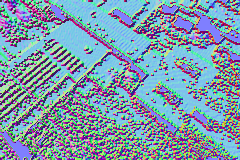

In [8]:
# Save kornia results
analyze_normal(norm_kornia.squeeze(0).cpu().numpy().transpose(1, 2, 0).reshape(-1, 3))

out_norm_kornia = norm_kornia.squeeze(0).cpu().numpy().transpose(1, 2, 0) # [H, W, 3]

out_norm_kornia += 1
out_norm_kornia /= 2
out_norm_kornia *= 255

cv2.imwrite('surface_normal_kornia.png', out_norm_kornia)

Image.fromarray(np.uint8(out_norm_kornia))

# Use open3d + cam_coords for surface normal estimation

In [9]:
pc = torch.tensor(pc_xyz_.transpose(2, 0, 1)).float()  # [3, H_ds, W_ds] = [3, 60, 90]

cam_to_world = cam_pose.copy()  # [4, 4]
world_to_cam = np.linalg.inv(cam_to_world)  # [4, 4]

world_coords = pc.reshape(3, -1)  # [3, N]
ones = torch.ones((1, world_coords.size(1)))  # [1, N]
world_coords = torch.cat([world_coords, ones], dim=0)  # [4, N]

mask_has_data = (pc[0] != -1).view(-1).numpy()  # [N]
cam_coords = torch.matmul(torch.tensor(world_to_cam[:3, :]).float(), world_coords.float())  # [3, N] <- [3, 4] x [4, N]
cam_coords = cam_coords.view(*pc.shape)  # [3, H_ds, W_ds] = [3, 60, 90]
cam_coords = cam_coords * (pc[0] != -1) + pc[0] * (pc[0] == -1)  # [3, H_ds, W_ds] = [3, 60, 90]
cam_coords = cam_coords.numpy().reshape(3, -1).transpose(1, 0)  # send in [N, 3] array
cam_coords = cam_coords[mask_has_data]  # valid xyz, [X, 3]
    
# cam_coords = torch.matmul(torch.tensor(world_to_cam[:3, :]).float(), world_coords.float())  # [3, N] <- [3, 4] x [4, N]
# cam_coords = cam_coords.view(*pc.shape)  # [3, H_ds, W_ds] = [3, 60, 90]
# cam_coords = cam_coords * (pc[0] != -1) + pc[0] * (pc[0] == -1)  # [3, H_ds, W_ds] = [3, 60, 90]
# cam_coords = cam_coords.numpy().reshape(3, -1).transpose(1, 0)  # send in [N, 3] array
# cam_coords = cam_coords[np.sum(cam_coords, axis=1) != -3]  # valid xyz, [X, 3]

time_start = time.time()
pc_o3d = o3d.geometry.PointCloud()
pc_o3d.points = o3d.utility.Vector3dVector(cam_coords)
pc_o3d.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=16))
pc_o3d.normalize_normals()
o3d.geometry.PointCloud.orient_normals_towards_camera_location(pc_o3d, [0, 0, 0])
time_o3d = time.time() - time_start
print("Time for surface normal estimation using open3d: {:.1f}ms".format(time_o3d * 1e3))

normals_o3d = pc.numpy().reshape(3, -1).transpose(1, 0)  # [N, 3]
normals_o3d[mask_has_data] = np.asarray(pc_o3d.normals)  # [X, 3]
normals_o3d = normals_o3d.reshape(pc.size(1), pc.size(2), 3).transpose(2, 0, 1)  # [3, H_ds, W_ds]
# normals_o3d = torch.tensor(normals_o3d, dtype=torch.float)

# o3d.visualization.draw_geometries([pc_o3d], point_show_normal=True)

Time for surface normal estimation using open3d: 58.6ms


Surface normal shape: (28933, 3), mean: -0.86, median: -0.90
Z-direction value: 28706 / 28933 negative, 227 / 28933 positive


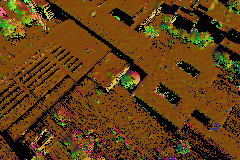

In [10]:
# Save o3d results
analyze_normal(np.array(pc_o3d.normals).reshape(-1, 3))

# out_norm_o3d = pc_xyz_.copy().reshape(-1, 3)
# out_norm_o3d[np.sum(out_norm_o3d, axis=1)!=-3] = np.array(pc_o3d.normals).reshape(-1, 3)
# out_norm_o3d = out_norm_o3d.reshape(pc_xyz_.shape)
# out_norm_o3d.shape

out_norm_o3d = normals_o3d.transpose(1, 2, 0)

out_norm_o3d += 1
out_norm_o3d /= 2
out_norm_o3d *= 255

cv2.imwrite('surface_normal_o3d_cam_coord.png', out_norm_o3d)

Image.fromarray(np.uint8(out_norm_o3d))

In [11]:
normals_o3d.shape
normal = torch.tensor(normals_o3d).float()
print(normal.shape)
print(torch.sum(normal==-1))
print(torch.sum(normal==0))
print(torch.sum(torch.logical_and(normal!=1, normal!=0)))
print(torch.numel(normal))

torch.Size([3, 160, 240])
tensor(0)
tensor(28401)
tensor(86799)
115200


# Use open3d + world_coords for surface normal estimation

In [12]:
# Use open3d for surface normal estimation
pc_o3d = o3d.geometry.PointCloud()
pc_o3d.points = o3d.utility.Vector3dVector(pc_xyz)
# o3d.io.write_point_cloud("clean_pc.ply", pc_o3d)

# pcd_load = o3d.io.read_point_cloud("clean_pc.ply")
pcd_load = pc_o3d

time_start = time.time()
o3d.geometry.PointCloud.estimate_normals(
    pcd_load,
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=50,
                                                      max_nn=500))
o3d.geometry.PointCloud.normalize_normals(pcd_load)
o3d.geometry.PointCloud.orient_normals_towards_camera_location(pcd_load, cam_pose[:3, -1])
time_o3d = time.time() - time_start
print("Time for surface normal estimation using open3d: {:.1f}ms".format(time_o3d * 1e3))

# o3d.visualization.draw_geometries([pcd_load], point_show_normal=True)

Time for surface normal estimation using open3d: 414.1ms


Surface normal shape: (28933, 3), mean: 0.62, median: 0.71
Z-direction value: 399 / 28933 negative, 28534 / 28933 positive


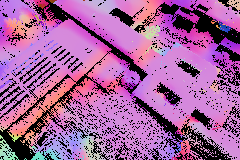

In [13]:
# Save o3d results
analyze_normal(np.array(pcd_load.normals).reshape(-1, 3))

out_norm_o3d = pc_xyz_.copy().reshape(-1, 3)
out_norm_o3d[np.sum(out_norm_o3d, axis=1)!=-3] = np.array(pcd_load.normals).reshape(-1, 3)
out_norm_o3d = out_norm_o3d.reshape(pc_xyz_.shape)
out_norm_o3d.shape

out_norm_o3d += 1
out_norm_o3d /= 2
out_norm_o3d *= 255

cv2.imwrite('surface_normal_o3d_world_coord.png', out_norm_o3d)

Image.fromarray(np.uint8(out_norm_o3d))

In [14]:
def norm_visualize(norm_mat, raw_image):
    """
    Visualize surface normal matrices.
    @param norm_mat [H, W, 3] numpy array
    @param raw_iamge [H, W, 3] numpy array
    """
    norm_mat += 1
    norm_mat /= 2
    norm_mat *= 255
    norm_mat = np.uint8(norm_mat)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].imshow(norm_mat)
    axes[0].axis('off')
    
    axes[1].imshow(raw_image)
    axes[1].axis('off')

def depth_visualize(depth_mat, raw_image):
    """
    Visualize z-buffer depth.
    @param depth_mat [H, W] numpy array
    @param raw_iamge [H, W, 3] numpy array
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].imshow(depth_mat, cmap='cividis')
    axes[0].axis('off')
    
    axes[1].imshow(raw_image)
    axes[1].axis('off')

1698 out of 5400 rows are removed becaues of no-data.
Surface normal shape: (3702, 3), mean: -0.88, median: -1.00
Z-direction value: 3645 / 3702 negative, 57 / 3702 positive


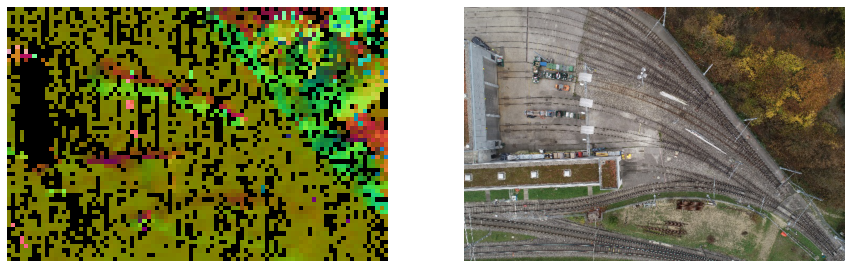

In [15]:
norms = sorted(glob.glob(os.path.abspath(os.path.join(os.getcwd(), '../datasets/EPFL/test_real/normal/*.dat'))))
raw_images = sorted(glob.glob(os.path.abspath(os.path.join(os.getcwd(), '../datasets/EPFL/test_real/rgb/*.png'))))

idx = np.random.randint(len(norms))
norm_mat = torch.load(norms[idx]).numpy().transpose(1, 2, 0)
analyze_normal(norm_mat.reshape(-1, 3))
rgb_image = io.imread(raw_images[idx])
norm_visualize(norm_mat, rgb_image)

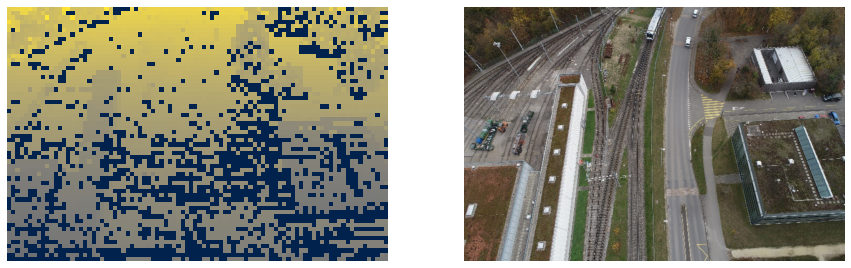

In [16]:
depths = sorted(glob.glob(os.path.abspath(os.path.join(os.getcwd(), '../datasets/EPFL/train_real/depth/*.dat'))))
raw_images = sorted(glob.glob(os.path.abspath(os.path.join(os.getcwd(), '../datasets/EPFL/train_real/rgb/*.png'))))

idx = np.random.randint(len(depths))
depth_visualize(torch.load(depths[idx]), io.imread(raw_images[idx]))

In [17]:
# Dataset sanity check
root_dir = '/home/qiyan/Documents/TransPose/datasets/EPFL'
things = glob.glob(os.path.join(root_dir, '*/*/*'))
for thing in things:
    assert os.path.exists(thing)